<a href="https://colab.research.google.com/github/Mobad225/Image-Panoramas/blob/master/CV_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Uploading the images and unzipping them.

In [0]:
os.chdir('/content')
from google.colab import files
files.upload();

Saving pics.zip to pics.zip


In [0]:
!unzip -q pics.zip -d Q1_Pics

# Loading up the images into img1 & img2

In [0]:
os.chdir('/content')
path = '/Q1_Pics/'
os.chdir(os.getcwd() + path)
img1 = cv2.cvtColor(cv2.imread(os.getcwd() + '/left.jpg'), cv2.COLOR_BGR2RGB);
img2 = cv2.cvtColor(cv2.imread(os.getcwd() + '/right.jpg'), cv2.COLOR_BGR2RGB);

# Function to print photos (for testing)

In [0]:
def print_photo(data_to_show, c_style = None, single = True, title = None,
                true_size = False, pts = []):
  if true_size == True:
    #USER SCREEN DPI
    dpi, dims = 118, data_to_show.shape
    dims_inch = (dims[1]/dpi, dims[0]/dpi)
    plt.figure(figsize=dims_inch)
  plt.axis('off')
  plt.title(title)
  if len(pts) > 0:
    plt.scatter(pts[:,0], pts[:,1], color = 'b')
  if single:
    plt.imshow(data_to_show, cmap = plt.get_cmap(c_style))
    plt.show()
    plt.close()
    print()
    return
  else:
    for curr_img in data_to_show:
      plt.axis('off')
      plt.imshow(curr_img, cmap = plt.get_cmap(c_style))
      plt.show()
      plt.close()
      print()
    return

# Resize the images

In [0]:
"""
dim = img1.shape
new_dims = (dim[1]//3, dim[0]//3)
img1 = cv2.resize(img1, new_dims, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, new_dims, interpolation = cv2.INTER_AREA)
""";

# Coordinates I chose from both photos

In [0]:
sims_1 = np.array([(995, 901, 810, 760, 599, 965, 562, 1000, 924, 814, 957),
                   (342, 339, 322, 495, 550, 423, 626, 350, 530, 321, 393)]).T
sims_2 = np.array([(540, 458, 369, 308, 139, 506, 87, 544, 461, 372, 501),
                   (325, 315, 293, 461, 513, 401, 595, 334, 500, 292, 372)]).T

# Picking the best points.

In [0]:
best1 = sims_1[7:10]
best2 = sims_2[7:10]

# Constructing the point matrices

In [0]:
after = np.reshape(best1, (len(best1)*2, 1))
H = np.zeros((len(after), 6))
for i in range(len(after)):
  curr_pt = best2[i//2]
  if i & 1 == 0:
    H[i] = np.append(curr_pt, [1, 0, 0, 0])
  else:
    H[i] = np.append(np.append([0, 0, 0], curr_pt), [1])

# Finding the degrees of freedom

In [0]:
H_inv = np.linalg.pinv(H)
degrees = H_inv.dot(after)
H_mat = np.reshape(np.append(degrees, [0, 0, 1]), (3, 3))
#print(H.dot(degrees)) <~~~ To check they are (x11,y11,x12,y12,x13,y13).T

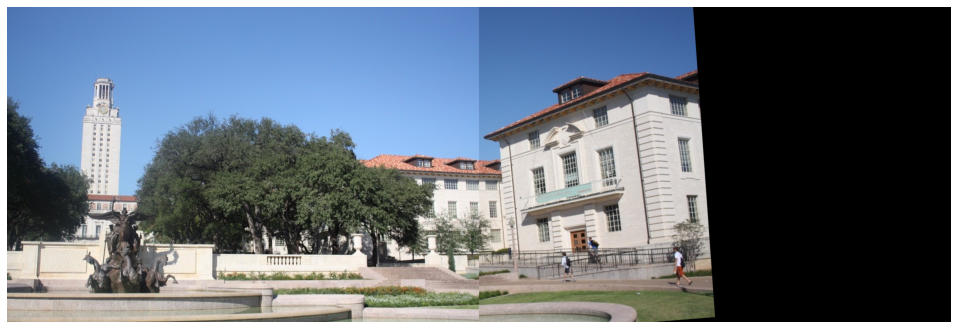

In [0]:
pts1 = np.float32(best1)
pts2 = np.float32(best2)

dst = cv2.warpPerspective(img2, H_mat,(img1.shape[1] + img2.shape[1], img1.shape[0]))
dst[0:img1.shape[0], 0:img1.shape[1]] = img1
print_photo(dst, true_size = True)

# BONUS : Using descriptors to detect points

## Using ORB to find keypoints and descriptors

In [0]:
orb = cv2.ORB_create(nfeatures=1000, scoreType=cv2.ORB_FAST_SCORE)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

## Visualizing key points' location

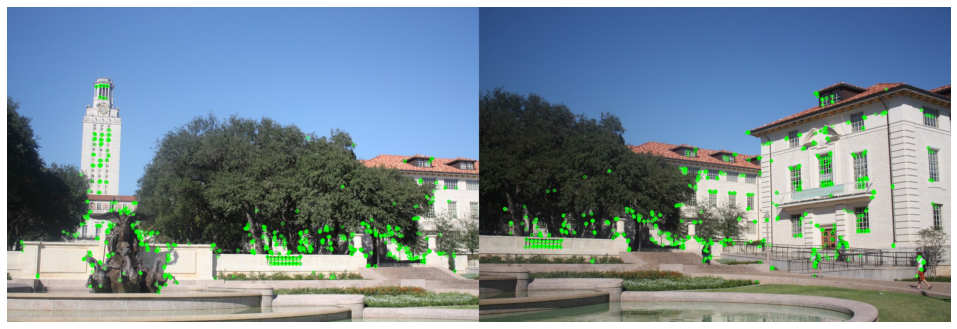

In [0]:
img_1, img_2 = img1, img2

# drawing only keypoints location,not size and orientation
img_1 = cv2.drawKeypoints(img1,kp1,np.array([]),color=(0,255,0), flags=0)
img_2 = cv2.drawKeypoints(img2,kp2,np.array([]),color=(0,255,0), flags=0)
both = np.concatenate((img_1, img_2), axis=1)
print_photo(both, true_size = True)

# Matching keypoints

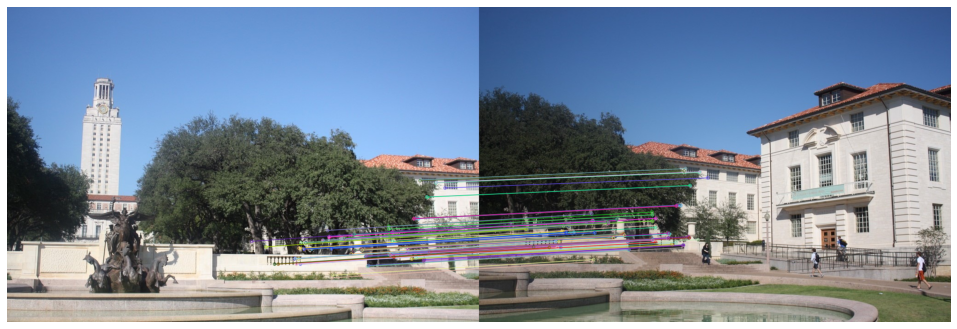

In [0]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:100],np.array([]), flags=2)
print_photo(img3, true_size = True)

## Taking Only first 15 matches for accuracy

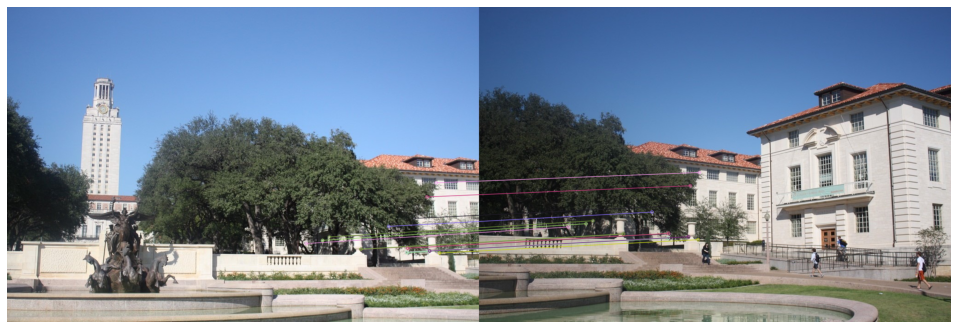

In [0]:
img4 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:15],np.array([]), flags=2)
print_photo(img4, true_size = True)

# Use best 15 matches to find Homography matrix

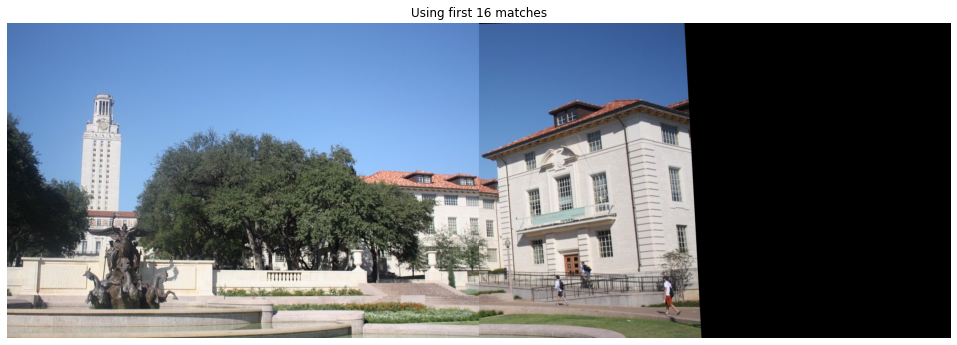

In [0]:
for mx in range(16,17):
  best1 = np.array([kp1[matches[i].queryIdx].pt for i in range(mx)])
  best2 = np.array([kp2[matches[i].trainIdx].pt for i in range(mx)])

  #Same code as above
  after = np.reshape(best1, (len(best1)*2, 1))
  H = np.zeros((len(after), 6))
  for i in range(len(after)):
    curr_pt = best2[i//2]
    if i & 1 == 0:
      H[i] = np.append(curr_pt, [1, 0, 0, 0])
    else:
      H[i] = np.append(np.append([0, 0, 0], curr_pt), [1])

  H_inv = np.linalg.pinv(H)
  degrees = H_inv.dot(after)
  H_mat = np.reshape(np.append(degrees, [0, 0, 1]), (3, 3))

  pts1 = np.float32(best1)
  pts2 = np.float32(best2)

  dst = cv2.warpPerspective(img2, H_mat,(img1.shape[1] + img2.shape[1], img1.shape[0]))
  dst[0:img1.shape[0], 0:img1.shape[1]] = img1
  print_photo(dst, true_size = True, title = 'Using first {} matches'.format(mx))